In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve
)
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")


In [2]:

# -----------------------------------------------------
#  Step 1: Load Test Data
# -----------------------------------------------------
test_df = pd.read_csv('./Data/Processed/test.csv')
X_test_texts = test_df['text']
y_test = test_df['label']

In [3]:

# -----------------------------------------------------
#  Step 2: Define Models
# -----------------------------------------------------
MODEL_PATHS = {
    "Logistic Regression": {
        "model": "./Logistic Regression/hate_speech_logreg.pkl",
        "vectorizer": "./Logistic Regression/tfidf_vectorizer.pkl"
    },
    "Naive Bayes": {
        "model": "./Naive Bayes/hate_speech_nb.pkl",
        "vectorizer": "./Naive Bayes/tfidf_vectorizer.pkl"
    },
    "Random Forest": {
        "model": "./Random Forest/hate_speech_rf.pkl",
        "vectorizer": "./Random Forest/tfidf_vectorizer.pkl"
    },
    "DistilBERT": {
        "model": "./Distilbert/hate_speech_distilbert"
    }
}

In [4]:
#------------------------------------------------------
#  Step 3: Utility Functions
# -----------------------------------------------------

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def plot_roc_curve(y_true, y_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

def plot_precision_recall(y_true, y_prob, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label='PR Curve')
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

In [5]:

# -----------------------------------------------------
#  Step 4: Core Evaluation Logic
# -----------------------------------------------------
def evaluate_model(model_name):
    info = MODEL_PATHS[model_name]
    print(f"\n{'='*70}\n🧠 Evaluating: {model_name}\n{'='*70}")

    if model_name == "DistilBERT":
        try:
            from transformers import AutoTokenizer, AutoModelForSequenceClassification
            import torch

            tokenizer = AutoTokenizer.from_pretrained(info['model'])
            model = AutoModelForSequenceClassification.from_pretrained(info['model'])
            model.eval()

            inputs = tokenizer(X_test_texts.tolist(), padding=True, truncation=True, return_tensors="pt")

            with torch.no_grad():
                outputs = model(**inputs)
                probs = torch.softmax(outputs.logits, dim=1).numpy()
                preds = np.argmax(probs, axis=1)

            y_pred = preds
            y_prob = probs[:, 1] if probs.shape[1] == 2 else None

        except Exception as e:
            print(f"⚠️ DistilBERT evaluation failed: {e}")
            return None

    else:
        # Load model + vectorizer
        model = joblib.load(info['model'])
        vectorizer = joblib.load(info['vectorizer'])
        X_test = vectorizer.transform(X_test_texts)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='binary', zero_division=0)
    rec = recall_score(y_test, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

    print("Classification Report:\n")
    print(classification_report(y_test, y_pred, zero_division=0))

    print("Test labels:", np.unique(y_test, return_counts=True))
    print("Predicted labels:", np.unique(y_pred, return_counts=True))



    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, model_name)

    if y_prob is not None and len(np.unique(y_test)) == 2:
        auc = roc_auc_score(y_test, y_prob)
        print(f"ROC-AUC Score: {auc:.4f}")
        plot_roc_curve(y_test, y_prob, model_name)
        plot_precision_recall(y_test, y_prob, model_name)
    else:
        print("⚠️ Skipping ROC/PR plots (probabilities unavailable).")

    # Return results
    return {
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1
    }


Available models:
1. Logistic Regression
2. Naive Bayes
3. Random Forest
4. DistilBERT

🧠 Evaluating: Logistic Regression
Accuracy: 0.7410
Precision: 0.7393
Recall: 0.7444
F1 Score: 0.7418

Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      5216
           1       0.74      0.74      0.74      5215

    accuracy                           0.74     10431
   macro avg       0.74      0.74      0.74     10431
weighted avg       0.74      0.74      0.74     10431

Test labels: (array([0, 1]), array([5216, 5215]))
Predicted labels: (array([0, 1]), array([5180, 5251]))


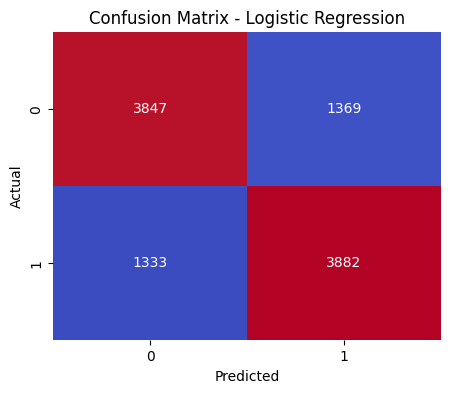

ROC-AUC Score: 0.8232


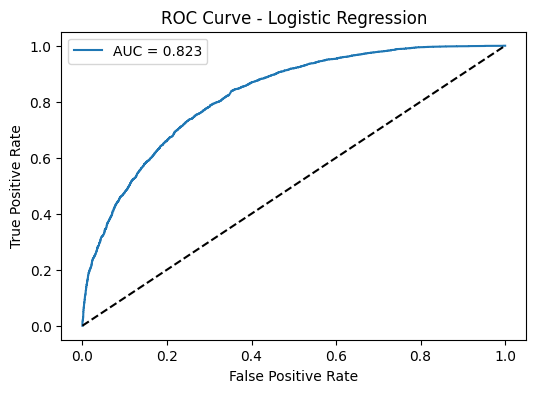

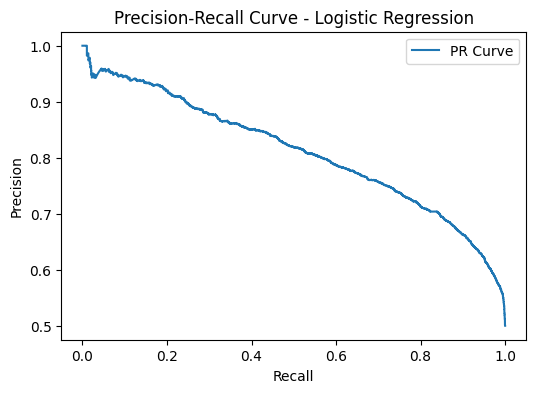


🧠 Evaluating: Naive Bayes
Accuracy: 0.7260
Precision: 0.7096
Recall: 0.7651
F1 Score: 0.7363

Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.69      0.71      5216
           1       0.71      0.77      0.74      5215

    accuracy                           0.73     10431
   macro avg       0.73      0.73      0.73     10431
weighted avg       0.73      0.73      0.73     10431

Test labels: (array([0, 1]), array([5216, 5215]))
Predicted labels: (array([0, 1]), array([4808, 5623]))


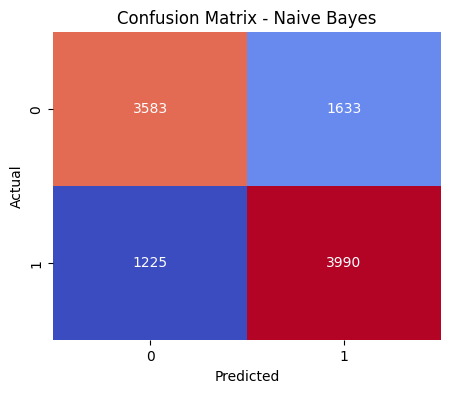

ROC-AUC Score: 0.8110


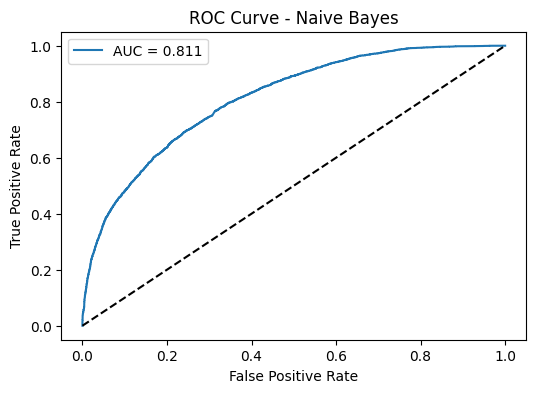

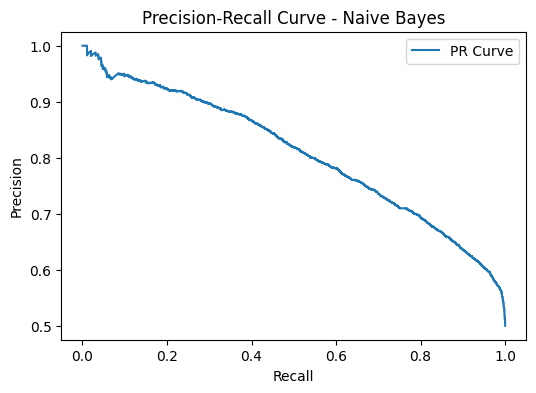


🧠 Evaluating: Random Forest
Accuracy: 0.8239
Precision: 0.8062
Recall: 0.8527
F1 Score: 0.8288

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      5216
           1       0.81      0.85      0.83      5215

    accuracy                           0.82     10431
   macro avg       0.82      0.82      0.82     10431
weighted avg       0.82      0.82      0.82     10431

Test labels: (array([0, 1]), array([5216, 5215]))
Predicted labels: (array([0, 1]), array([4915, 5516]))


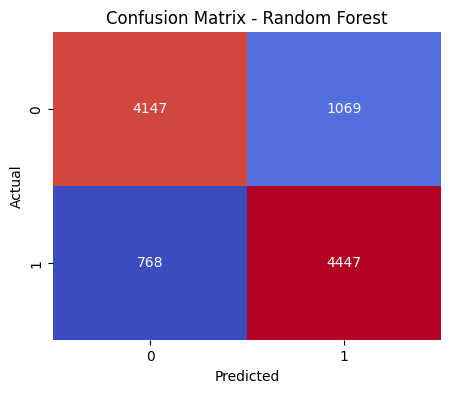

ROC-AUC Score: 0.9074


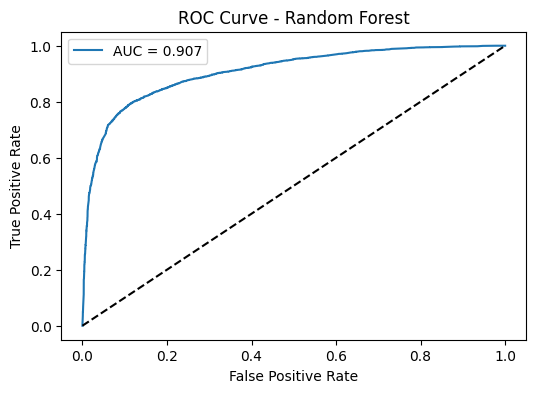

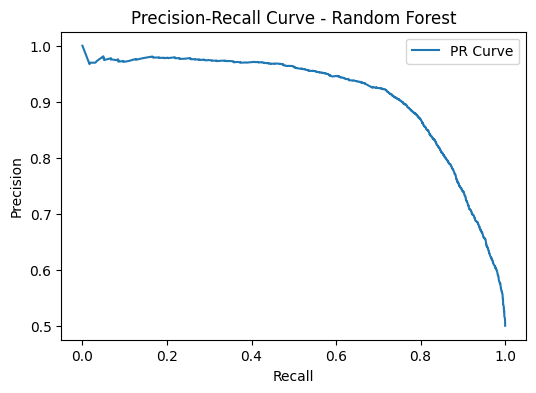


📊 Summary Table:



,Model,Accuracy,Precision,Recall,F1
2,Random Forest,0.823890,0.806200,0.852733,0.828814
0,Logistic Regression,0.740964,0.739288,0.744391,0.741831
1,Naive Bayes,0.726009,0.709586,0.765101,0.736298


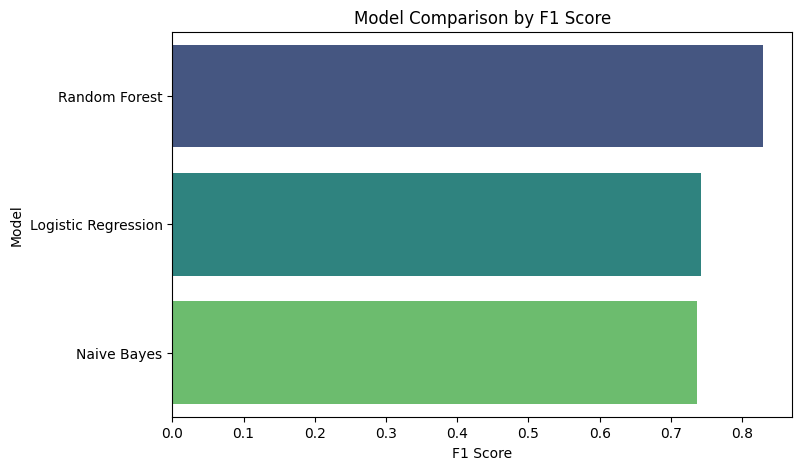

In [6]:
# -----------------------------------------------------
#  Step 5:Manual Model Selection
# -----------------------------------------------------

print("Available models:")
for i, name in enumerate(MODEL_PATHS.keys(), 1):
    print(f"{i}. {name}")

selected = input("\nEnter model numbers separated by commas (e.g., 1,3): ")
selected_ids = [int(x.strip()) for x in selected.split(",") if x.strip().isdigit()]
selected_models = [list(MODEL_PATHS.keys())[i-1] for i in selected_ids]

results = []

for model_name in selected_models:
    res = evaluate_model(model_name)
    if res:
        results.append(res)

if results:
    results_df = pd.DataFrame(results).sort_values(by='F1', ascending=False)
    print("\n📊 Summary Table:\n")
    display(results_df)

    plt.figure(figsize=(8, 5))
    sns.barplot(data=results_df, x='F1', y='Model', palette='viridis')
    plt.title("Model Comparison by F1 Score")
    plt.xlabel("F1 Score")
    plt.ylabel("Model")
    plt.show()
